# Data
netflex/src/data.ipynb by Jens Brage (jens.brage@noda.se)

In [18]:
import matplotlib
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = [21, 13]
import networkx
import time

In [2]:
import cvxpy
import numpy
import pandas

/Users/jens/anaconda3/envs/cvxpy/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from netflex import *

The data folder contains price and temperature data for the three years below. Select one year, e.g., yyyy = years[2] to work with the corresponding data.

In [4]:
years = 2010, 2013, 2015

In [5]:
def read_csv(path):
    df = pandas.read_csv(path)
    for col in df:
        df[col] = pandas.to_numeric(df[col], errors='coerce').ffill()
    return df

The price of electricity over the different years, smoothed over a rolling window of 7 * 24 hours to emphasize the large scale behaviour.

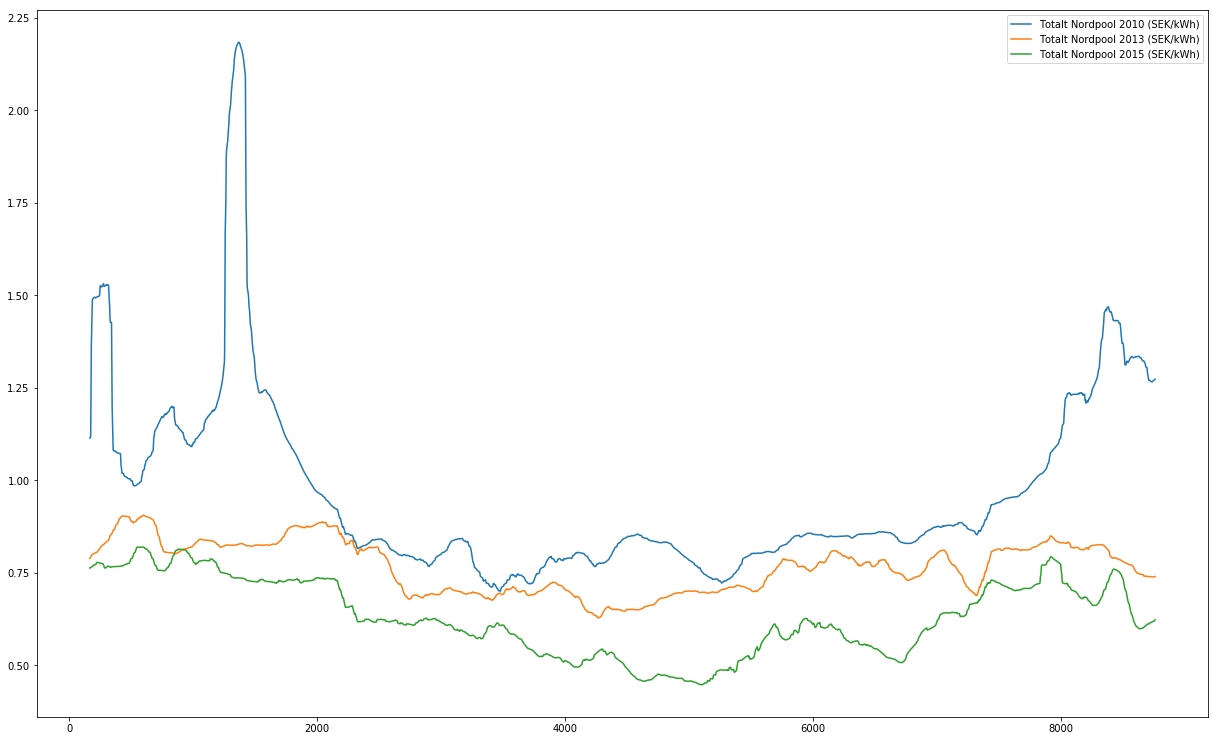

In [19]:
elpris = read_csv('data/elpris.csv')
elpris[['Totalt Nordpool %s (SEK/kWh)' % yyyy for yyyy in years]].rolling(7 * 24).mean().plot()

The corresponding climate data processed in the same way.

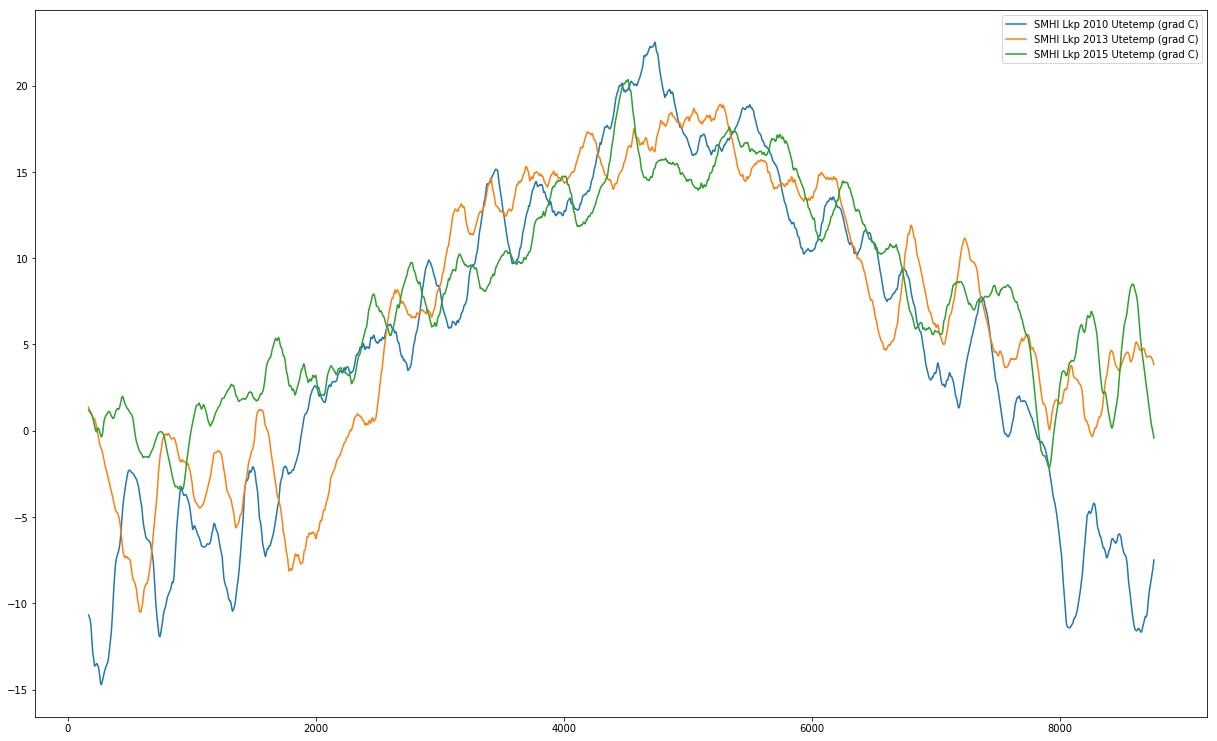

In [20]:
klimat = read_csv('data/klimat.csv')
klimat[['SMHI Lkp %s Utetemp (grad C)' % yyyy for yyyy in years]].rolling(7 * 24).mean().plot()

To perform model predictive control by means of convex optimization, the COP needs to be approximated by an affine function only depending on exogenous variables, here the outdoor temperature. The example below (4.6e0 + 5.8e-2 * c) is intended to model a modern installation.

In [21]:
def cop(c):
    return 4.6e0 + 5.8e-2 * c

Compile the data into one dataframe and save the result.

In [22]:
def data(yyyy):
    df = pandas.DataFrame()
    df['%s' % yyyy] = elpris['Årstimme']
    df['mm'] = elpris['Månad']
    df['dd'] = elpris['Dag']
    df['HH'] = elpris['Timme']
    df['SEK/kWh'] = elpris['Totalt Nordpool %s (SEK/kWh)' % yyyy]
    df['C'] = klimat['SMHI Lkp %s Utetemp (grad C)' % yyyy]
    df['COP'] = cop(df['C'])
    df.set_index('%s' % yyyy, inplace=True)
    df.to_csv('data/%s.csv' % yyyy)
    return df

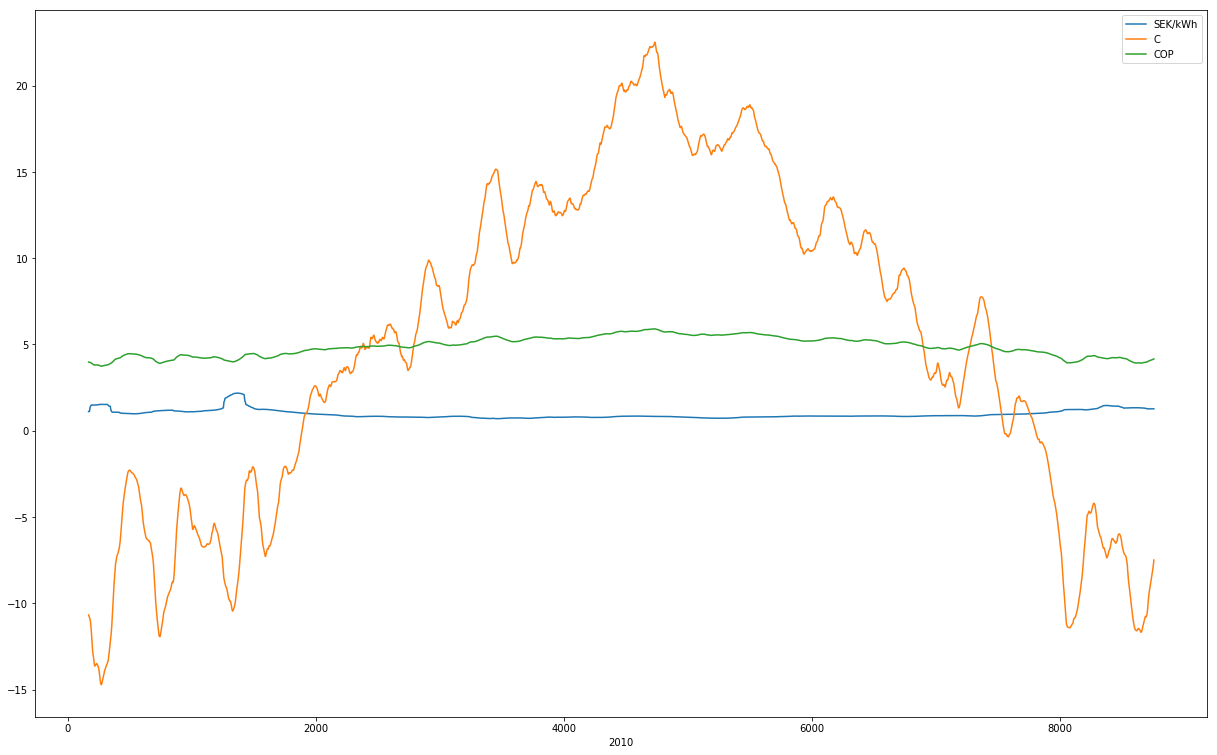

In [23]:
df = data(years[0])
df[['SEK/kWh', 'C', 'COP']].rolling(7 * 24).mean().plot()

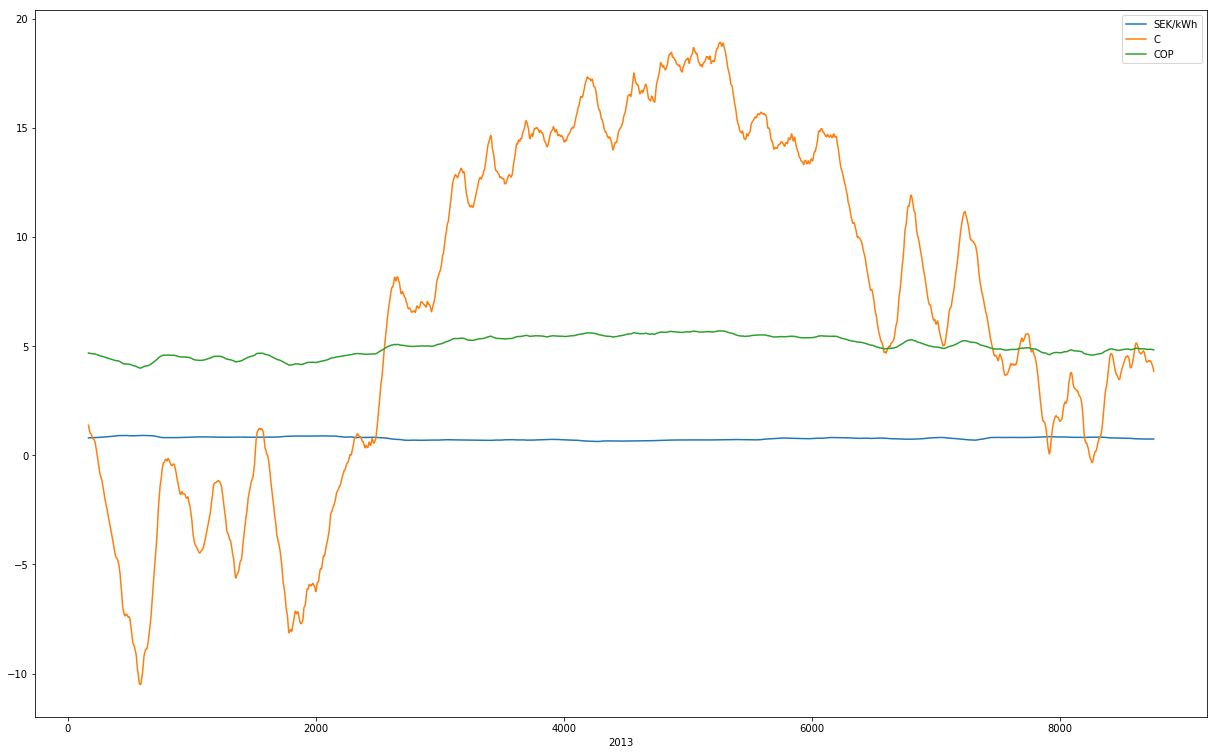

In [24]:
df = data(years[1])
df[['SEK/kWh', 'C', 'COP']].rolling(7 * 24).mean().plot()

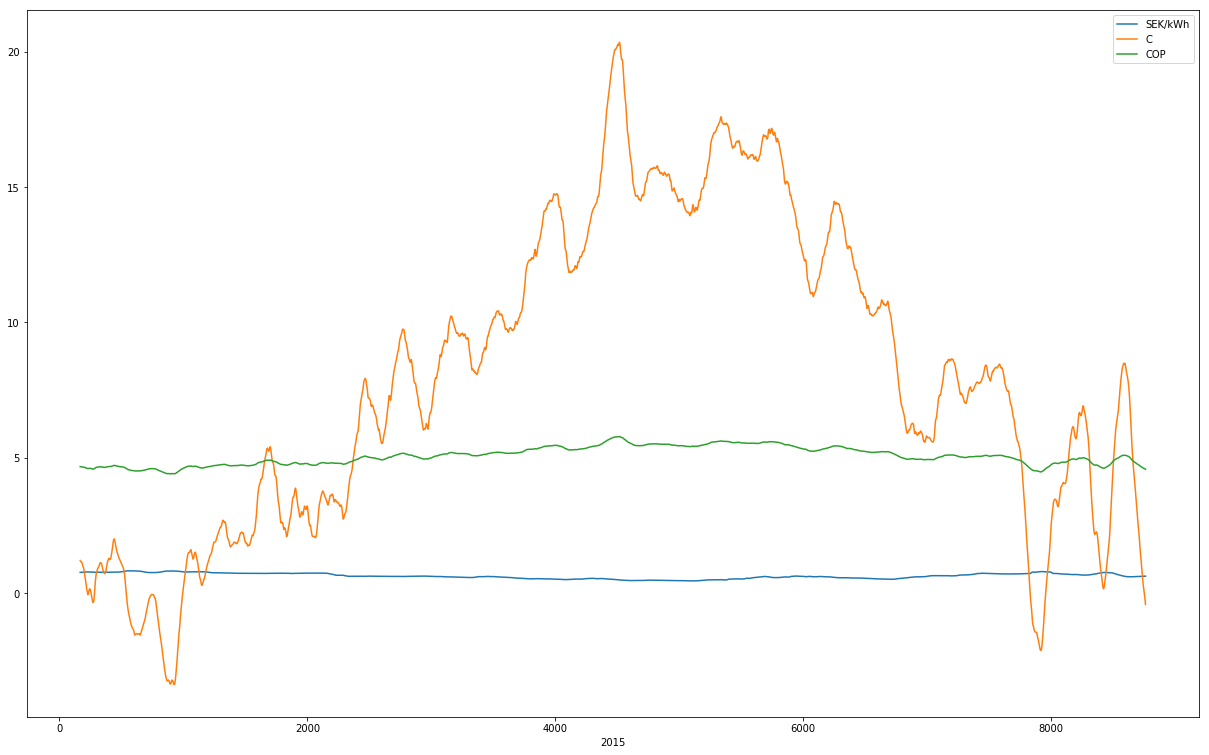

In [25]:
df = data(years[2])
df[['SEK/kWh', 'C', 'COP']].rolling(7 * 24).mean().plot()

In Scandinavia, buildings are often configured to consume heat in proportion to an affine or almost affine function of the outdoor temperature, a so called heat curve, and such buildings can be controlled by means of overriding the percieved outdoor temperature. The values below reflect the behaviour of a number of larger buildings somewhere in Sweden.

In [26]:
esig = pandas.DataFrame(
    [
        [7.827e2, -2.971e1], # sum(array[1 :])
        [1.194e2, -3.555e0],
        [1.123e2, -5.319e0],
        [1.057e2, -6.448e0],
        [9.103e1, -2.276e0],
        [8.989e1, -2.571e0],
        [8.190e1, -2.939e0],
        [6.578e1, -2.693e0],
        [6.239e1, -2.943e0],
        [5.429e1, -0.964e0],
    ],
    columns=['kWh', 'kWh/C'],
)
esig.to_csv('data/esig.csv')
esig

,kWh,kWh/C
0,782.70,-29.710
1,119.40,-3.555
2,112.30,-5.319
3,105.70,-6.448
4,91.03,-2.276
5,89.89,-2.571
6,81.90,-2.939
7,65.78,-2.693
8,62.39,-2.943
9,54.29,-0.964


In [27]:
def test(yyyy):
    df = pandas.read_csv('data/%s.csv' % yyyy, index_col=0)
    c = df['C']
    for i in range(0, 10):
        m, k = esig.loc[i]
        df['m%r' % i] = m
        df['k%r' % i] = k
        df['x%r' % i] = (m + k * c).clip(0.0e0)
        df[Agent.PREFIX + 'x%r' % i] = 0.0e0
    df.to_csv('test/%s.csv' % yyyy)
    return df

The graphs below show the development of demand for heat over the year. It is a simple model, but often good enough for practical purposes. However, note that the model is invalid for the warmer part of the year, for which heating tend to be sitched off.

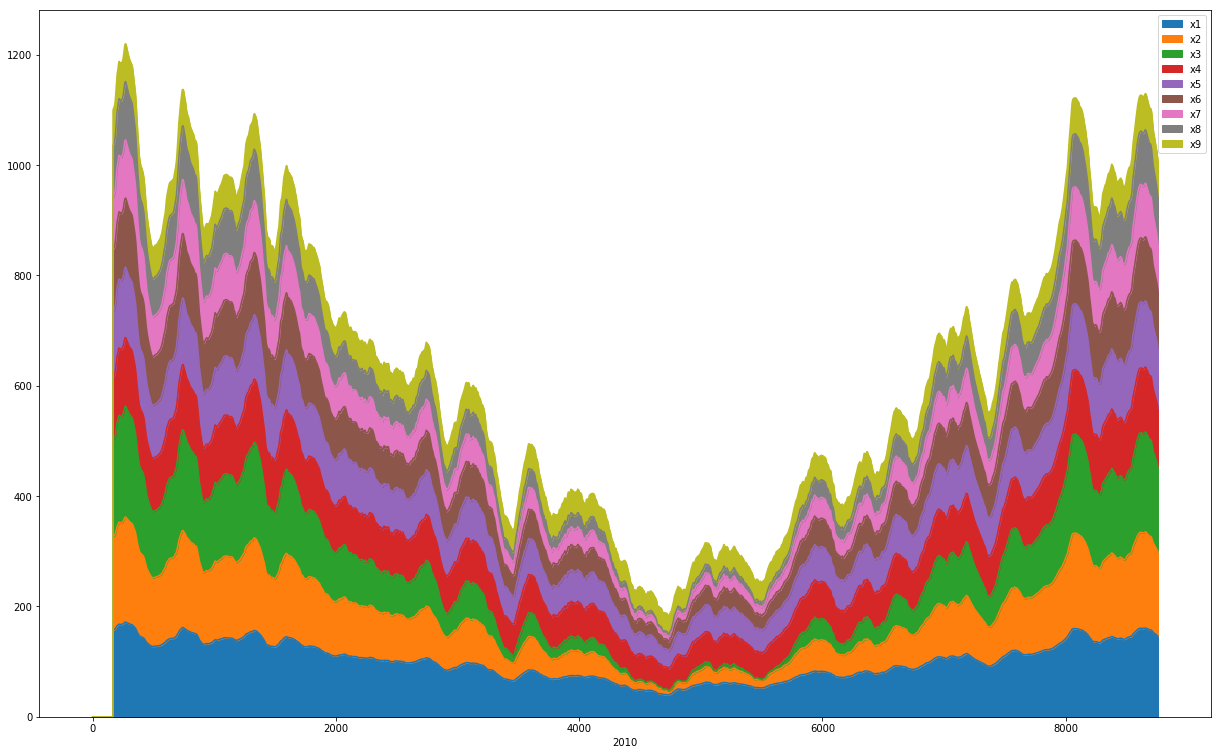

In [28]:
df = test(years[0])
df[['x%r' % i for i in range(1, 10)]].rolling(7 * 24).mean().plot(kind='area')

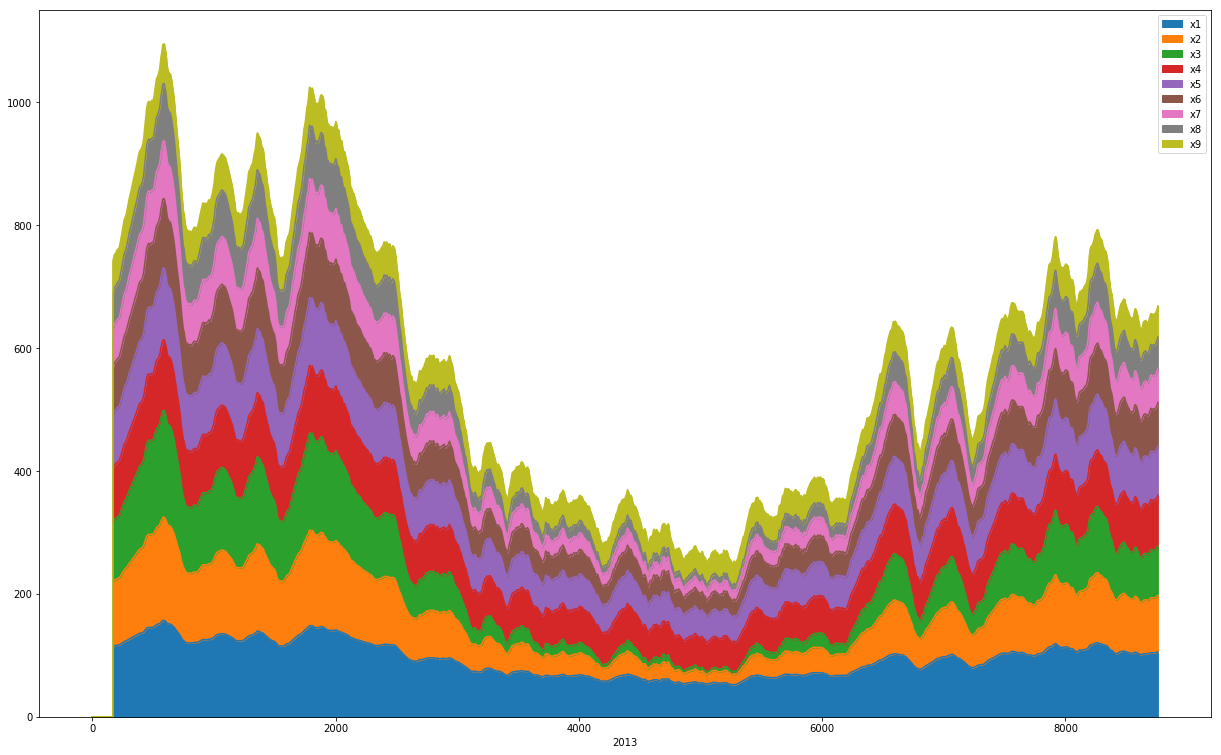

In [29]:
df = test(years[1])
df[['x%r' % i for i in range(1, 10)]].rolling(7 * 24).mean().plot(kind='area')

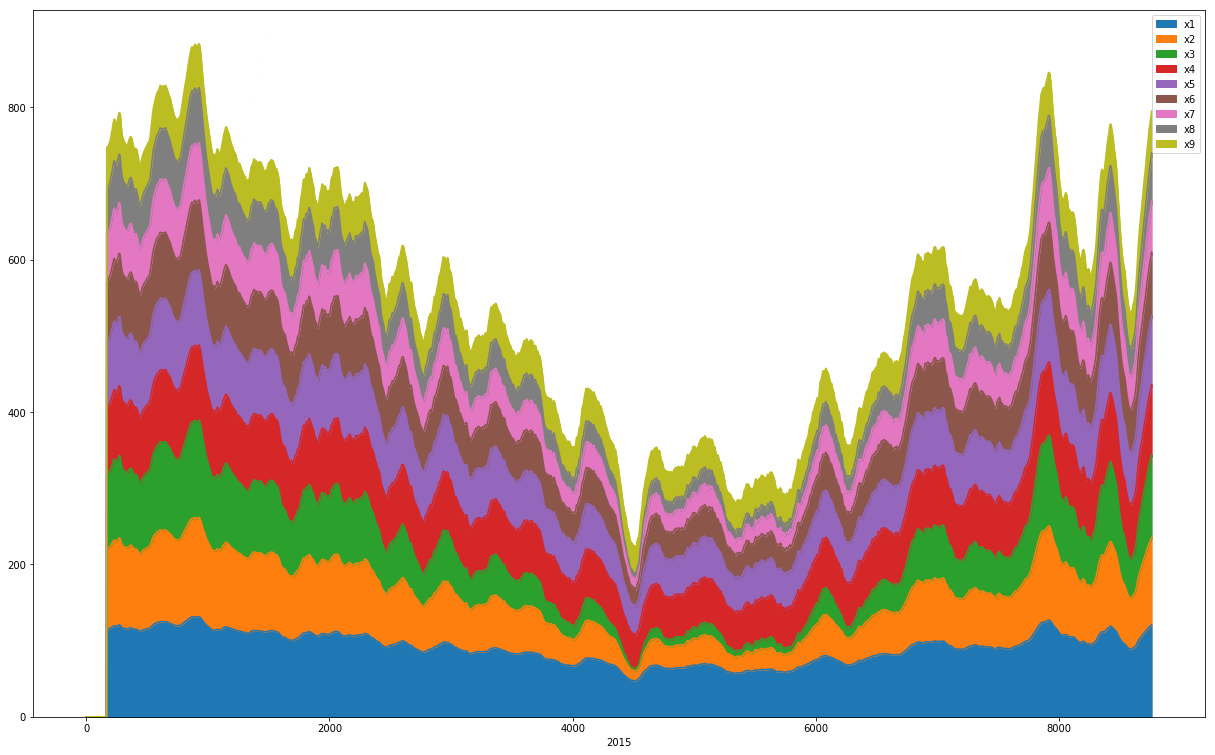

In [30]:
df = test(years[2])
df[['x%r' % i for i in range(1, 10)]].rolling(7 * 24).mean().plot(kind='area')